# Generate a training set of images and annotations

We'll use the [PASCAL VOC2012](http://host.robots.ox.ac.uk/pascal/VOC/voc2012/) and [PASCAL-Part](http://www.stat.ucla.edu/~xianjie.chen/pascal_part_dataset/pascal_part.html) images and annotations as a training set for UNet.

Let's download both datasets first:

In [1]:
# Uncomment the following lines to download and extract VOC2012 and PASCAL-Part data
# !mkdir data
# !wget http://host.robots.ox.ac.uk/pascal/VOC/voc2012/VOCtrainval_11-May-2012.tar -P ./data
# !tar xf ./data/VOCtrainval_11-May-2012.tar -C ./data
# !rm -rf ./data/VOCtrainval_11-May-2012.tar
# !wget http://www.stat.ucla.edu/~xianjie.chen/pascal_part_dataset/trainval.tar.gz -P ./data
# !tar xfz ./data/trainval.tar.gz -C ./data
# !rm -rf ./data/trainval.tar.gz

In [2]:
import numpy as np
import os
import pickle
import warnings

from matplotlib.pyplot import imshow
from skimage.color import rgb2gray
from skimage.io import imread
from skimage.transform import resize

from anno import ImageAnnotation

warnings.filterwarnings('ignore')
%matplotlib inline

## Structure of input and output tensors

We'll feed the Convolutional Neural Network with 368x368 normalized grayscale frames (pixel values between 0 and 1). UNet seems to work better with a single input channel, but RGB input should be explored too. The output tensor consists of two 368x368 binary matrices. On the first one, a 1 means that the object to be segmented is being detected on that pixel or 0 otherwise. The second matrix is the opposite of the first, a 1 means that background is present in that pixel and a 0 means that the object is there.

We'll generate ground-truth data of cars to train a car-segmentation UNet model.

## Parse VOC2012 annotations

First we get a list of images that are segmented.

In [3]:
original_dir = './data/VOCdevkit/VOC2012/JPEGImages'
segmented_dir = './data/VOCdevkit/VOC2012/SegmentationClass'

In [4]:
with open('./data/VOCdevkit/VOC2012/ImageSets/Segmentation/trainval.txt', 'r') as f:
    segmented = [line.strip() for line in f.readlines()]

Let's analyze a segmented car image:

In [5]:
name = '2007_001321'
original_img = imread(os.path.join(original_dir, '{}.jpg'.format(name)))
segment_img = imread(os.path.join(segmented_dir, '{}.png'.format(name)))

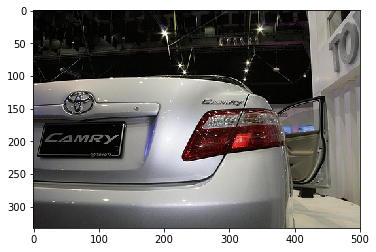

In [6]:
imshow(original_img)

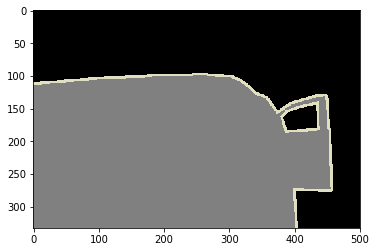

In [7]:
imshow(segment_img)

In [8]:
colors = set()
for i in range(segment_img.shape[0]):
    for j in range(segment_img.shape[0]):
        r, g, b = segment_img[i, j, :]
        colors.add((r, g, b))
print(colors)

{(224, 224, 192), (0, 0, 0), (128, 128, 128)}


Cars are segmented with gray (128, 128, 128) pixels in the VOC2012 annotations. We can then generate the correct output matrix for this segment pretty easily:

In [9]:
mask = np.all(segment_img == (128, 128, 128), axis=-1)
output_segment = np.zeros(mask.shape)
output_segment[mask] = 1.

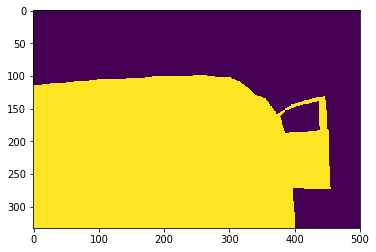

In [10]:
imshow(output_segment)

Let's also explore a handy calculation which returns the percentage of the image covered by a car:

In [11]:
output_segment.sum() / output_segment.shape[0] / output_segment.shape[1]

0.5596636636636637

56% of the image is covered by the car, this is useful when cars only fill a small percentage of the image and are too small to be segmented.

The last preprocess needed is converting the input to grayscale and resizing both input and output to a 368x368xChannels shape.

In [12]:
height = 368
width = 368

(368, 368, 1)

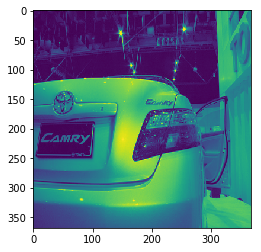

In [13]:
input_img = resize(rgb2gray(original_img), (height, width), anti_aliasing=True).reshape((height, width, 1))
imshow(input_img[:, :, 0])
input_img.shape

(368, 368, 2)

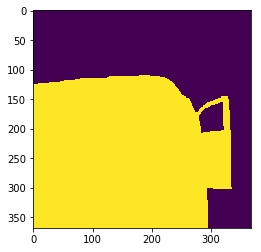

In [14]:
output_segment = resize(output_segment, (height, width), anti_aliasing=True)
output_segment[output_segment > 0.] = 1.
output_back = np.ones(output_segment.shape)
output_back[output_segment > 0.] = 0.
output = np.stack([output_segment, output_back], axis=-1)
imshow(output[:,:,0])
output.shape

## Generate VOC2012 train set

Now it's time to iterate through all the segmented images and add the ones with large enough cars to our train set.

Let's define the general constants to generate the train set which could be modified to generate a set of segments of any other class.

In [15]:
# Input/output sizes
height = 368
width = 368
# Class we want to detect
segment_color = (128, 128, 128)  # Cars
# Percentage of the image covered by this class
threshold = 0.05

In [16]:
input_images = []
output_tensors = []

In [17]:
for name in segmented:
    original_img = imread(os.path.join(original_dir, '{}.jpg'.format(name)))
    segment_img = imread(os.path.join(segmented_dir, '{}.png'.format(name)))
    mask = np.all(segment_img == segment_color, axis=-1)
    output_segment = np.zeros(mask.shape)
    output_segment[mask] = 1.
    if output_segment.sum() / output_segment.shape[0] / output_segment.shape[1] > threshold:
        image = resize(rgb2gray(original_img), (height, width), anti_aliasing=True).reshape((1, height, width, 1))
        output_segment = resize(output_segment, (height, width), anti_aliasing=True)
        output_segment[output_segment > 0.] = 1.
        output_back = np.ones(output_segment.shape)
        output_back[output_segment > 0.] = 0.
        tensor = np.stack([output_segment, output_back], axis=-1).reshape((1, height, width, 2))
        input_images.append(image)
        output_tensors.append(tensor)

In [18]:
print("Images collected: {}".format(len(input_images)))

Images collected: 147


Let's check we have gathered the correct images:

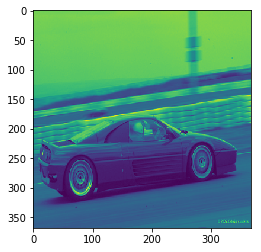

In [19]:
imshow(input_images[32][0, :, :, 0])

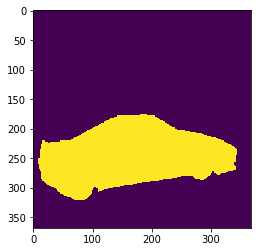

In [20]:
imshow(output_tensors[32][0, :, :, 0])

## Parse PASCAL-Part Dataset

The 147 images from VOC2012 may be not sufficient to train a good model. There's another useful annotated dataset that we've downloaded: [PASCAL-Part](http://www.stat.ucla.edu/~xianjie.chen/pascal_part_dataset/pascal_part.html). It is based on the VOC2010 data, so we expect some of the images to be repeated. We only save those that aren't already part of the VOC2012 segmented images.

This dataset comes in `.mat` format, we use slightly modified [pascal-part-py](https://github.com/twuilliam/pascal-part-py) helpers to quickly parse these files.

In [21]:
annotations_dir = './data/Annotations_Part/'
voc2012 = set(segmented)

In [22]:
segmented = []
for annotation in os.listdir(annotations_dir):
    name = annotation.split('.')[0]
    if name in voc2012:
        continue
    ann = ImageAnnotation(
        os.path.join(original_dir, '{}.jpg'.format(name)),
        os.path.join(annotations_dir, '{}.mat'.format(name))
    )
    if 'car' in [ann.objects[i].class_name for i in range(ann.n_objects)]:
        segmented.append(name)

In [23]:
print("There is an additional number of {0} images of cars in the PASCAL-Part dataset.".format(len(segmented)))

There is an additional number of 877 images of cars in the PASCAL-Part dataset.


## Generate PASCAL-Part train set

Let's add those images where cars occupy a large enough portion of the image to the train set:

In [24]:
for name in segmented:
    ann = ImageAnnotation(
        os.path.join(original_dir, '{}.jpg'.format(name)),
        os.path.join(annotations_dir, '{}.mat'.format(name))
    )
    if ann.part_mask.sum() / ann.part_mask.shape[0] / ann.part_mask.shape[1] > threshold:
        image = resize(rgb2gray(ann.im), (height, width), anti_aliasing=True).reshape(1, height, width, 1)
        output_segment = resize(ann.part_mask, (height, width), anti_aliasing=True)
        output_segment[output_segment > 0.] = 1.
        output_back = np.ones(output_segment.shape)
        output_back[output_segment > 0.] = 0.
        tensor = np.stack([output_segment, output_back], axis=-1).reshape((1, height, width, 2))
        input_images.append(image)
        output_tensors.append(tensor)

Again, let's check we have gathered the correct images:

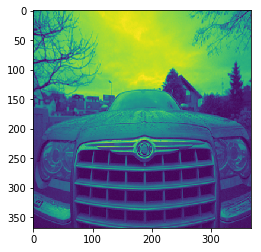

In [25]:
imshow(input_images[-1][0, :, :, 0])

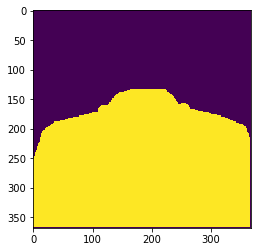

In [26]:
imshow(output_tensors[-1][0, :, :, 0])

In [27]:
print("Images collected: {}".format(len(input_images)))

Images collected: 665


## Concatenate and pickle final dataset

Let's save input and output tensors as *ndarray*s of shape (N, height, width, channels) and pickle them for training UNet networks.

In [28]:
input_images = np.concatenate(input_images, axis=0)
output_tensors = np.concatenate(output_tensors, axis=0)

In [29]:
print("Input tensor shape: {}".format(input_images.shape))
print("Output tensor shape: {}".format(output_tensors.shape))

Input tensor shape: (665, 368, 368, 1)
Output tensor shape: (665, 368, 368, 2)


In [30]:
with open('train_images.pkl', 'wb') as fout:
    pickle.dump(input_images, fout, protocol=4)
with open('train_labels.pkl', 'wb') as fout:
    pickle.dump(output_tensors, fout, protocol=4)